### Import the necessary packages

In [86]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import matplotlib.image as mpimg
import copy

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Input, Flatten, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.layers import DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Activation

import scipy
from scipy import stats, fft, signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Initial parameters

In [87]:
# Fixed parameters
#--------------------
Fs = 250                # Dataset sampling frequency
start_sample = -100     # Start of the tiral (ms after the cue)
n_channel = 60          # Number of EEG channels

# Hyperparameters
#--------------------
F1 = 4              # Number of frequency filters
D = 2               # Number of spatial filters in each frequency sub-band
F2 = F1*D           # Number of SeparableConv2D filters
T1 = 128            # Temporal kernel size (samples) in the first convolution
T2 = 32             # Temporal kernel size (samples) in SeparableConv2D
drop_rate = 0.2     # Droupout rate
Thr_proposed = 56   # Proposed CDS threshold
Thr_common = 50     # Common CDS threshold being used in the literature

# Choosing the data subset
#--------------------
T_type = 'emotional'    # Trials type (neutral - emotional)
Analysis = 'touch'      # Type of waves to analyse (touch - difference)

### Loading the dataset

In [88]:
# Loading the dataset
print('loading the dataset ... ')
npzfile = np.load('./DPD_processed_data.npz', allow_pickle=True) 
X = npzfile['X']
dtmep = {}
for key in X.item().keys():
    dtmep[key] = X.item()[key]
X = dtmep           # EEG data
Y = npzfile['Y']    # CDS scores
Z = npzfile['Z']    # User ID

# Changing data format and extracting data subset
for key in X.keys():
    X[key] = np.float32(X[key])
    X[key] = np.transpose(X[key], (2, 0, 1))
    X[key] = X[key][:,:,:,np.newaxis]
Y = np.squeeze(np.float32(Y))
Z = np.squeeze(Z)

X_original = copy.deepcopy(X)
if Analysis == 'touch':
    X = np.stack((X['Left_touch'], X['Right_touch']), axis=-1)
if Analysis == 'difference':
    X = np.stack((X['Left_touch'] - X['Left_no_touch'], X['Right_touch'] - X['Right_no_touch']), axis=-1)

loading the dataset ... 


### Defining the network

In [89]:
def Network(Chans, Samples, out_type = 'train'):
    #=======================================================================================
    # Network layers analysing left-hand touch
    #=======================================================================================
    left_input = Input(shape = (Chans, Samples, 1))
    block1 = Conv2D(F1, (1, T1), use_bias = False, activation = 'linear', padding='same', kernel_initializer = 'he_normal',
                   name = 'Spectral_filter_left')(left_input)
    block1 = BatchNormalization()(block1)
    block1 = Dropout(drop_rate)(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias = False, padding='valid', depth_multiplier = D, activation = 'linear',
                             depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), 
                             depthwise_initializer = 'he_normal', 
                            name = 'Spatial_filter_left')(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    source_left = block1

    block1 = AveragePooling2D((1, 2))(block1)
    block1 = Dropout(drop_rate)(block1)

    block1 = SeparableConv2D(F2, (1, T2), use_bias = False, activation = 'linear', padding = 'same' ,
                            kernel_initializer = 'he_normal')(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(drop_rate)(block1)
    
    embedded_left    = Flatten(name = 'Embedded_left')(block1)
    
    #=======================================================================================
    # Network layers analysing right-hand touch
    #=======================================================================================
    
    right_input = Input(shape = (Chans, Samples, 1))
    block2 = Conv2D(F1, (1, T1), use_bias = False, activation = 'linear', padding='same', kernel_initializer = 'he_normal',
                   name = 'Spectral_filter_right')(right_input)
    block2 = BatchNormalization()(block2)
    block2 = Dropout(drop_rate)(block2)
    block2 = DepthwiseConv2D((Chans, 1), use_bias = False, padding='valid', depth_multiplier = D, activation = 'linear',
                             depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1),
                             depthwise_initializer = 'he_normal', 
                            name = 'Spatial_filter_right')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    source_right = block2

    block2 = AveragePooling2D((1, 2))(block2)
    block2 = Dropout(drop_rate)(block2)

    block2 = SeparableConv2D(F2, (1, T2), use_bias = False, activation = 'linear', padding = 'same',
                            kernel_initializer = 'he_normal')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 4))(block2)
    block2 = Dropout(drop_rate)(block2)
    
    embedded_right    = Flatten(name = 'Embedded_right')(block2)

    #=======================================================================================
    # Concatenating low-dimensional representation of left and right touch
    #=======================================================================================    
    embedded = Concatenate(axis = -1)([embedded_left, embedded_right])
    
    reg         = Dense(1, use_bias = False, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(), 
                        name = 'Regression')(embedded)
    
    clustering  = Dense(2, use_bias = False, activation = 'softmax',
                        kernel_constraint = tf.keras.constraints.NonNeg(),
                        name='Clustering')(embedded)
    
    if out_type == 'evaluation':
        return Model(inputs = [left_input, right_input], outputs = [reg, clustering, embedded, source_left, source_right])

    else:
        return Model(inputs = [left_input, right_input], outputs = [reg, clustering])

### Low-dimensional representation

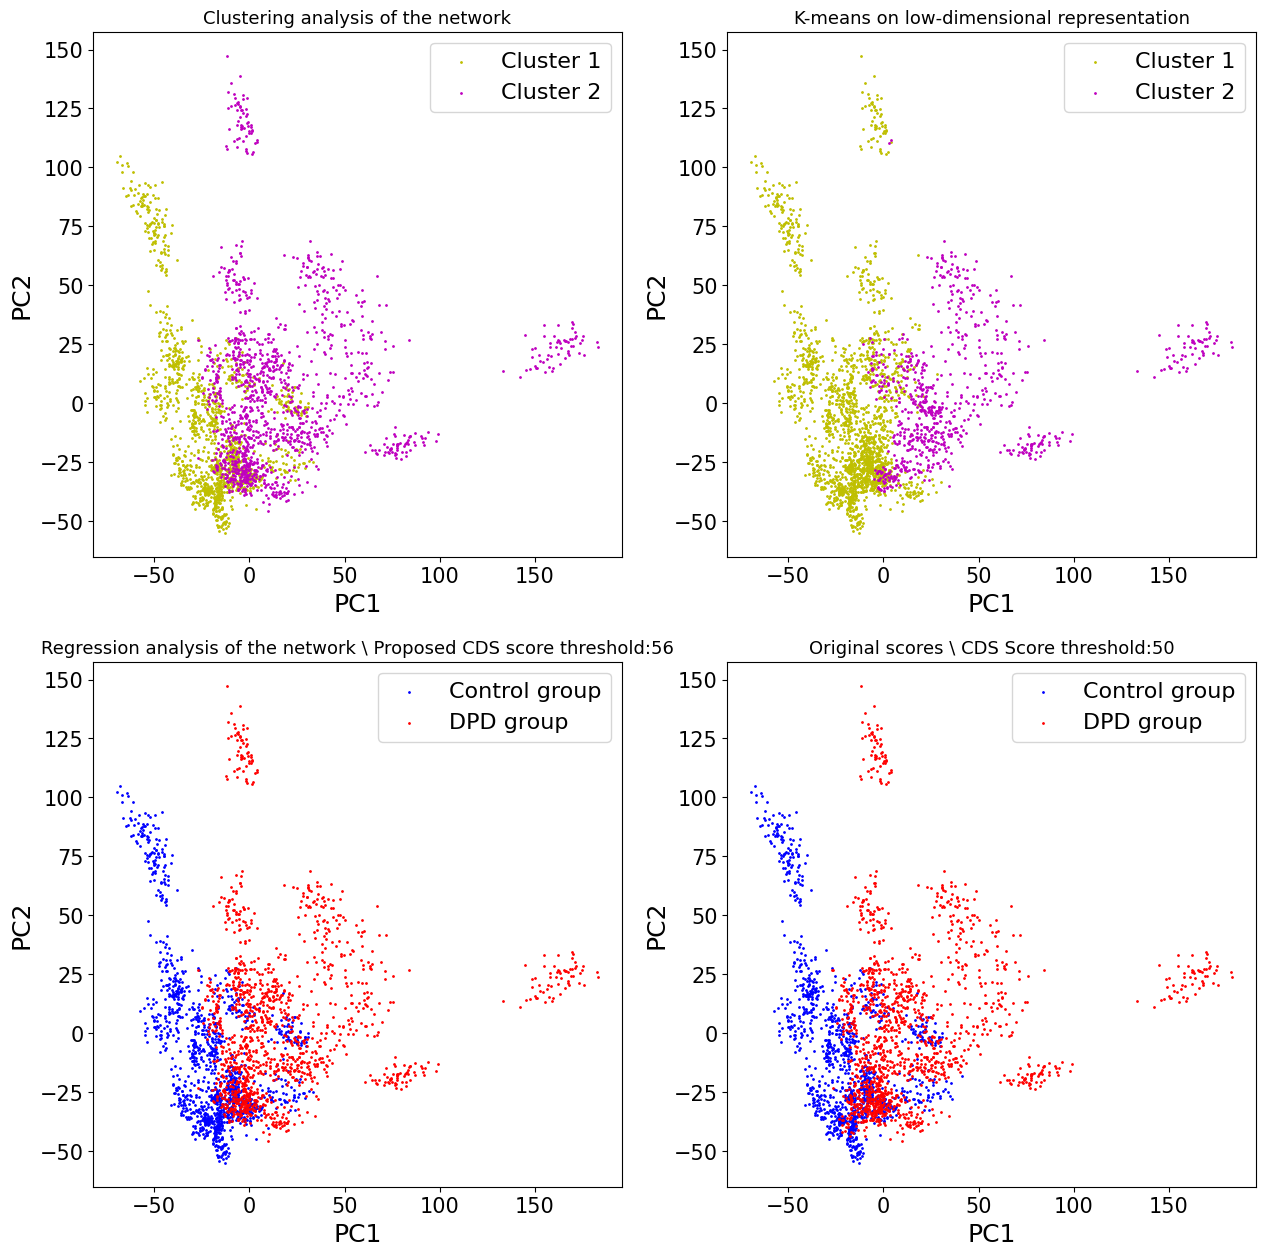

In [90]:
# Building the model and loading trained weights
_, Chans, Samples, _, _ = X.shape
model = Network(Chans, Samples, out_type = 'evaluation')
model.load_weights('./checkpoints/my_checkpoint')

# Concatenating the two types of input to form a single input tensor
All_input = [X[:,:,:,:,0],X[:,:,:,:,1]]

# Initialising subplots
fig, ax = plt.subplots(2,2, figsize=(15,15))
def axs_info(title, axs_id):
    ax[axs_id[0],axs_id[1]].set_title(title, fontsize= 13)
    ax[axs_id[0],axs_id[1]].legend(fontsize= 16)
    ax[axs_id[0],axs_id[1]].set_xlabel('PC1', fontsize= 18)
    ax[axs_id[0],axs_id[1]].set_ylabel('PC2', fontsize= 18)
    ax[axs_id[0],axs_id[1]].tick_params(axis='both', labelsize=15)

# Scatter plot based on:
#------------------------------------------------------------------------
# the output of clustering analysis/branch
#------------------------------------------------------------------------
Embedded = model(All_input)[2].numpy()
labels = np.argmax(model(All_input)[1].numpy(),axis=1)
Cluster_labels = [stats.mode(i).mode for i in [labels[Z==i] for i in np.unique(Z)]]
C1_sub = np.unique(Z)[np.squeeze(Cluster_labels) == 0]
C2_sub = np.unique(Z)[np.squeeze(Cluster_labels) == 1]
C1_idx = np.array([i in C1_sub for i in Z])
C2_idx = np.array([i in C2_sub for i in Z])

pca = PCA(n_components=2)
pca.fit(Embedded)
Embedded_temp = pca.transform(Embedded)

if len(np.unique(labels))>1:
    ax[0,0].scatter(Embedded_temp[(labels==0),0],Embedded_temp[(labels==0),1], c = 'y', s =1, marker='o',
                label='Cluster 1')
    ax[0,0].scatter(Embedded_temp[(labels==1),0],Embedded_temp[(labels==1),1], c = 'm', s =1, marker='o',
                label='Cluster 2')
else:
    if np.unique(labels)==0: 
        ax[0,0].scatter(Embedded_temp[(labels==0),0],Embedded_temp[(labels==0),1], c = 'y', s =1, marker='o',
                    label='Cluster 1')
        print('\nAll the training trials have been assigned to the cluster 1')
    elif np.unique(labels)==1:
        ax[0,0].scatter(Embedded_temp[(labels==1),0],Embedded_temp[(labels==1),1], c = 'm', s =1, marker='o',
                    label='Cluster 2')   
        print('\nAll the training trials have been assigned to the cluster 2')

axs_info('Clustering analysis of the network', [0,0])

# Scatter plot based on:
#------------------------------------------------------------------------
# K-means on latent representation
#------------------------------------------------------------------------
kmeans = KMeans(n_clusters=2, random_state=0).fit(Embedded)
labels = kmeans.predict(Embedded)
ax[0,1].scatter(Embedded_temp[(labels==0),0],Embedded_temp[(labels==0),1], c = 'y', s =1, marker='o',
            label='Cluster 1')
ax[0,1].scatter(Embedded_temp[(labels==1),0],Embedded_temp[(labels==1),1], c = 'm', s =1, marker='o',
            label='Cluster 2')

axs_info('K-means on low-dimensional representation', [0,1])   

# Scatter plot based on:
#------------------------------------------------------------------------
# the output of regression analysis/branch with the proposed threshold of 56
#------------------------------------------------------------------------
labels = np.squeeze(model(All_input)[0].numpy())
Reg_labels = [np.mean(i) for i in [labels[Z==i] for i in np.unique(Z)]]
DPD_sub = np.unique(Z)[np.squeeze(Reg_labels) >= Thr_proposed]
control_sub = np.unique(Z)[np.squeeze(Reg_labels) < Thr_proposed]
DPD_idx = np.array([i in DPD_sub for i in Z])
control_idx = np.array([i in control_sub for i in Z])

ax[1,0].scatter(Embedded_temp[labels<Thr_proposed,0],
            Embedded_temp[labels<Thr_proposed,1],
            c = 'b', s =1, marker='o',label='Control group')

ax[1,0].scatter(Embedded_temp[labels>=Thr_proposed,0],
            Embedded_temp[labels>=Thr_proposed,1],
            c = 'r', s =1, marker='o', label='DPD group')

axs_info('Regression analysis of the network' +' \\ Proposed CDS score threshold:' + str(Thr_proposed), [1,0])   

# Scatter plot based on:
#------------------------------------------------------------------------
# reported CDS scores with the common threshold of 50
#------------------------------------------------------------------------
ax[1,1].scatter(Embedded_temp[np.squeeze(Y<Thr_common),0],
            Embedded_temp[np.squeeze(Y<Thr_common),1],
            c = 'b', s =1, marker='o',label='Control group')

ax[1,1].scatter(Embedded_temp[np.squeeze(Y>=Thr_common),0],
            Embedded_temp[np.squeeze(Y>=Thr_common),1],
            c = 'r', s =1, marker='o', label='DPD group')

axs_info('Original scores' +' \\ CDS Score threshold:' + str(Thr_common), [1,1])   

plt.show() 

### Network visualisation

##### Custom functions needed for visualisation

In [91]:
# Normalise spatial weights
def NormalizeData(data, names):
    N_list = [0,0]
    for f in range(F1):
        weights_spat = []
        for d in range(D):
            spat_name = 'Spatial_filter_' + T_type + '/depthwise_kernel:0'
            weights_spat_temp = model.get_weights()[names.index(spat_name)][:,:,f,d]
            weights_spat_temp = np.squeeze(weights_spat_temp)
            try: 
                weights_spat = np.vstack((weights_spat,weights_spat_temp))
            except:
                weights_spat = weights_spat_temp


        try:
            weights_spat = np.linalg.pinv(weights_spat)
        except:
            weights_spat = weights_spat[np.newaxis,:]
            weights_spat = np.linalg.pinv(weights_spat)

        weights_spat = np.abs(weights_spat)

        N_list[0] = np.minimum(np.min(weights_spat),N_list[0])
        N_list[1] = np.maximum(np.max(weights_spat),N_list[1])
    
    return (data - N_list[0]) / (N_list[1] - N_list[0])

# Fast Fourier transform function
def FFT(t, y):
    n = len(t)
    Δ = (max(t) - min(t)) / (n-1)
    k = int(n/2)
    f = np.arange(k) / (n*Δ)
    Y = abs(fft.fft(y))[:k]
    return (f, Y)

# Plot axis configuration
def ax_info(axes, title, S1, S2, ax_id):
    axes[ax_id].legend(fontsize = 15, loc='best')
    axes[ax_id].axvline(x=0, c = 'k', ls = 'dashed')
    axes[ax_id].axhline(y=0, c = 'k', ls = 'dashed')
    axes[ax_id].set_title(title, fontsize = 20)

##### Choosing trial type and returning subject assignments

In [92]:
T_type = input('Which type of trials do you want to visualsie (left - right)? ')

# Showing subjects' ID assigned to each group
print('\nBased on \033[1m clustering \033[0m analysis ...')
print(len(C1_sub), 'subjects in cluster 1: ', [int(i) for i in C1_sub])
print(len(C2_sub), 'subjects in cluster 2: ', [int(i) for i in C2_sub])
print('\nBased on \033[1m regressions \033[0m analysis ...')
print(len(control_sub), 'subjects in the control group: ', [int(i) for i in control_sub])
print(len(DPD_sub), 'subjects in the DPD group: ', [int(i) for i in DPD_sub])
report_labels = [np.mean(i) for i in [Y[Z==i] for i in np.unique(Z)]]
DPD_sub_act = np.unique(Z)[np.squeeze(report_labels) >= Thr_common]
control_sub_act = np.unique(Z)[np.squeeze(report_labels) < Thr_common]
DPD_idx_act = np.array([i in DPD_sub_act for i in Z])
control_idx_act = np.array([i in control_sub_act for i in Z])
print('\nBased on \033[1m reported \033[0m scores ...')
print(len(control_sub_act), 'subjects in the control group: ', [int(i) for i in control_sub_act])
print(len(DPD_sub_act), 'subjects in the DPD group: ', [int(i) for i in DPD_sub_act], '\n')


Based on  clustering  analysis ...
21 subjects in cluster 1:  [4, 6, 7, 10, 12, 15, 16, 17, 24, 26, 30, 32, 34, 39, 40, 46, 47, 48, 49, 50, 51]
22 subjects in cluster 2:  [2, 3, 5, 8, 9, 11, 13, 14, 23, 25, 27, 28, 31, 33, 35, 36, 37, 38, 41, 42, 43, 45]

Based on  regressions  analysis ...
21 subjects in the control group:  [4, 6, 7, 10, 12, 15, 16, 17, 24, 26, 30, 32, 34, 39, 40, 46, 47, 48, 49, 50, 51]
22 subjects in the DPD group:  [2, 3, 5, 8, 9, 11, 13, 14, 23, 25, 27, 28, 31, 33, 35, 36, 37, 38, 41, 42, 43, 45]

Based on  reported  scores ...
19 subjects in the control group:  [4, 6, 10, 12, 15, 16, 17, 24, 30, 32, 34, 39, 40, 46, 47, 48, 49, 50, 51]
24 subjects in the DPD group:  [2, 3, 5, 7, 8, 9, 11, 13, 14, 23, 25, 26, 27, 28, 31, 33, 35, 36, 37, 38, 41, 42, 43, 45] 



##### Spectral and spatial information visualisation


Visualising sources obtained for left touch/no_touch trials ... 



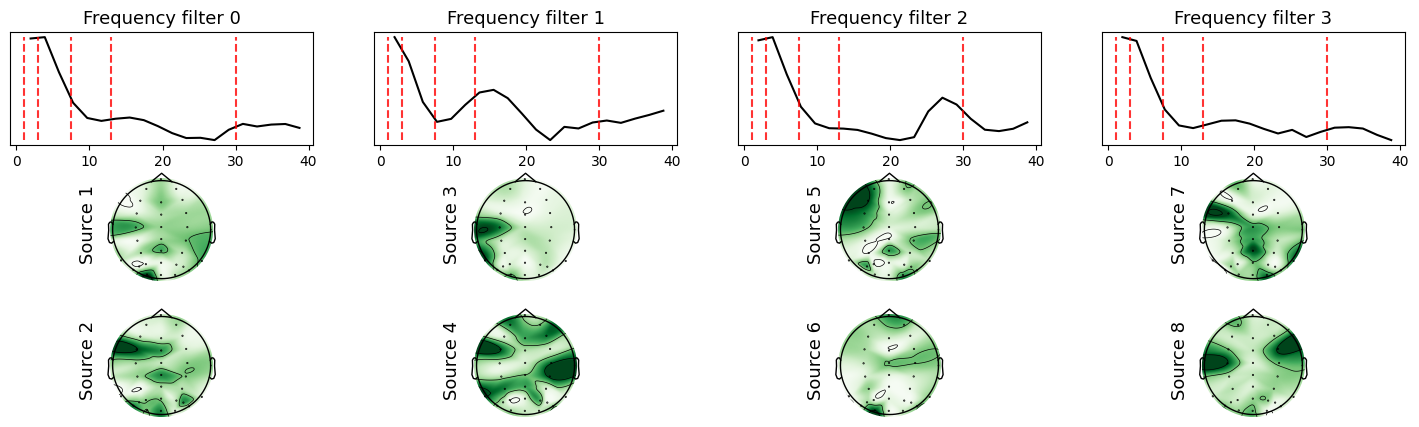

In [93]:
print('\n\033[1m' + 'Visualising sources obtained for ' + T_type + ' touch/no_touch trials ... ' + '\033[0m\n')
# Loading channel location
loc = mne.channels.read_custom_montage('Channel_locations_30.loc', coord_frame = 'head')
loc_info = mne.create_info(loc.ch_names, sfreq=Fs, ch_types='eeg')
fig, axes = plt.subplots(figsize=(18, 5), nrows=D+1, ncols=F1)

names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

#------------------------------------------------------------------------
# Spectral information visualisation
#------------------------------------------------------------------------
counter = 1
for f in range(F1):
    spec_name = 'Spectral_filter_' + T_type + '/kernel:0'
    weights_freq = model.get_weights()[names.index(spec_name)][:,:,:,f]
    weights_freq = np.squeeze(weights_freq)
    weights_freq = weights_freq-np.mean(weights_freq)
    t = np.linspace(0, weights_freq.size/Fs, num=weights_freq.size)
    y = weights_freq[::-1]
    (F, FFT_out) = FFT(t, y)
    FFT_out = scipy.signal.savgol_filter(FFT_out, 25,8)


    axes[0,f].plot(F[1:int(len(F)/3)], FFT_out[1:int(len(F)/3)], c = 'k')
    axes[0,f].set_title('Frequency filter {}'.format(f), fontsize=13)
    axes[0,f].set_yticks([])
    axes[0,f].vlines([1,3,7.5,13,30], min(FFT_out[1:int(len(F)/3)]), max(FFT_out[1:int(len(F)/3)]), 
                     'r', alpha = 0.8, linestyles = 'dashed')

    #------------------------------------------------------------------------
    # Spatial information visualisation
    #------------------------------------------------------------------------
    weights_spat = []
    for d in range(D):
        spat_name = 'Spatial_filter_' + T_type + '/depthwise_kernel:0'
        weights_spat_temp = model.get_weights()[names.index(spat_name)][:,:,f,d]
        weights_spat_temp = np.squeeze(weights_spat_temp)
        try: 
            weights_spat = np.vstack((weights_spat,weights_spat_temp))
        except:
            weights_spat = weights_spat_temp

    try:
        weights_spat = np.linalg.pinv(weights_spat)
    except:
        weights_spat = weights_spat[np.newaxis,:]
        weights_spat = np.linalg.pinv(weights_spat)
        if f == 0:
            print('There is only one spatial filter or the inverse of the weight matrix does not exists')


    for d in range(D):
        weights_spat_temp = weights_spat[:,d]
        weights_spat_temp = weights_spat_temp[:,np.newaxis]
        
        weights_spat_temp = np.abs(weights_spat_temp)
        weights_spat_temp = NormalizeData(weights_spat_temp, names)
        
        fake_evoked = mne.EvokedArray(weights_spat_temp, loc_info)
        fake_evoked.set_montage(loc)

        im,cm = mne.viz.plot_topomap(np.squeeze(fake_evoked.data), fake_evoked.info, axes=axes[d+1,f], 
                             cmap = 'Greens',
                             show=False, outlines = 'head', contours= 2, res = 100)
        axes[d+1,f].set_ylabel('Source '+str(counter), fontsize = 13)
        counter+=1

plt.show()

##### Temporal information visualisation in the source domain

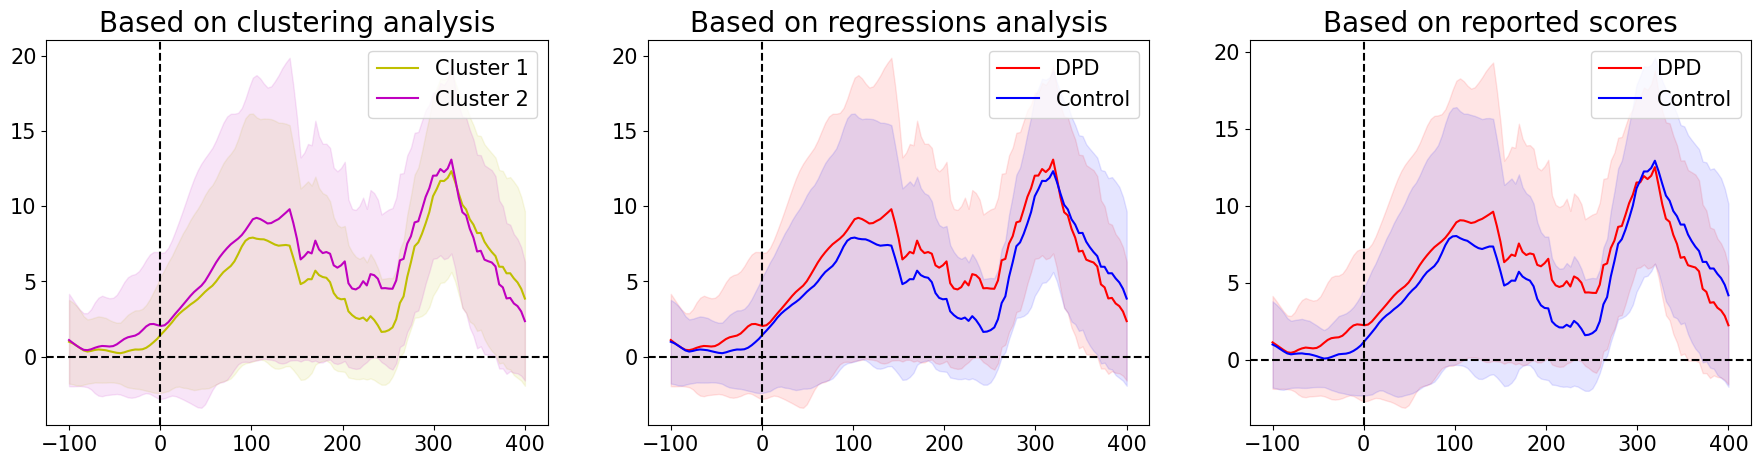


The independent t-test to analyse source 5 between groups in 280-320ms time window:
p-values

    Clustering analysis:	0.50172
    Regressions analysis:	0.50172
    Reported scores:	0.88542


In [94]:
SourceVis = int(input('\nWhich of the above sources do you want to analyse? (insert 0 to stop) '))

if T_type=='left':
    s_signal = np.squeeze(model(All_input)[3].numpy()[:,:,:,SourceVis-1])

elif T_type=='right':
    s_signal = np.squeeze(model(All_input)[4].numpy()[:,:,:,SourceVis-1])

fig_temp, axes_temp = plt.subplots(figsize=(22, 5), nrows=1, ncols=3)
t_trial = np.linspace(-100,400,s_signal.shape[-1])

#------------------------------------------------------------------------

axes_temp[0].plot(t_trial, np.mean(s_signal[C1_idx], axis = 0), 'y', label = 'Cluster 1')
error = np.std(s_signal[C1_idx], axis = 0)
axes_temp[0].fill_between(t_trial, np.mean(s_signal[C1_idx], axis = 0)-error, 
                            np.mean(s_signal[C1_idx], axis = 0)+error, alpha = 0.1, color = 'y')

axes_temp[0].plot(t_trial, np.mean(s_signal[C2_idx], axis = 0), 'm', label = 'Cluster 2')
error = np.std(s_signal[C2_idx], axis = 0)
axes_temp[0].fill_between(t_trial, np.mean(s_signal[C2_idx], axis = 0)-error, 
                            np.mean(s_signal[C2_idx], axis = 0)+error, alpha = 0.1, color = 'm')

ax_info(axes_temp, 'Based on clustering analysis', s_signal[C1_idx], s_signal[C2_idx], 0)
axes_temp[0].tick_params(axis='both', labelsize=15)

#------------------------------------------------------------------------

axes_temp[1].plot(t_trial, np.mean(s_signal[DPD_idx], axis = 0), 'r', label = 'DPD')
error = np.std(s_signal[DPD_idx], axis = 0)
axes_temp[1].fill_between(t_trial, np.mean(s_signal[DPD_idx], axis = 0)-error, 
                            np.mean(s_signal[DPD_idx], axis = 0)+error, alpha = 0.1, color = 'r')

axes_temp[1].plot(t_trial, np.mean(s_signal[control_idx], axis = 0), 'b', label = 'Control')
error = np.std(s_signal[control_idx], axis = 0)
axes_temp[1].fill_between(t_trial, np.mean(s_signal[control_idx], axis = 0)-error, 
                            np.mean(s_signal[control_idx], axis = 0)+error, alpha = 0.1, color = 'b')

ax_info(axes_temp, 'Based on regressions analysis', s_signal[DPD_idx], s_signal[control_idx], 1)
axes_temp[1].tick_params(axis='both', labelsize=15)

#------------------------------------------------------------------------

axes_temp[2].plot(t_trial, np.mean(s_signal[DPD_idx_act], axis = 0), 'r', label = 'DPD')
error = np.std(s_signal[DPD_idx_act], axis = 0)
axes_temp[2].fill_between(t_trial, np.mean(s_signal[DPD_idx_act], axis = 0)-error, 
                            np.mean(s_signal[DPD_idx_act], axis = 0)+error, alpha = 0.1, color = 'r')

axes_temp[2].plot(t_trial, np.mean(s_signal[control_idx_act], axis = 0), 'b', label = 'Control')
error = np.std(s_signal[control_idx_act], axis = 0)
axes_temp[2].fill_between(t_trial, np.mean(s_signal[control_idx_act], axis = 0)-error, 
                            np.mean(s_signal[control_idx_act], axis = 0)+error, alpha = 0.1, color = 'b')

ax_info(axes_temp, 'Based on reported scores', s_signal[DPD_idx_act], s_signal[control_idx_act], 2)
axes_temp[2].tick_params(axis='both', labelsize=15)
plt.show()

#------------------------------------------------------------------------
# Performing statistical analysis in the source domain
#------------------------------------------------------------------------

t_range = input('\nSelect time window for statistical test (low-high) >> (insert 0 to skip) ')
if t_range!= '0':
    [low, high] = [int((float(i)-start_sample)*Fs/1000) for i in t_range.split('-')]
    
    print("""\nThe independent t-test to analyse source %d between groups in %sms time window:\np-values\n
    Clustering analysis:\t%2.5f
    Regressions analysis:\t%2.5f
    Reported scores:\t%2.5f"""
    % (SourceVis, t_range,
        stats.ttest_ind([np.mean(i[low:high]) for i in \
                        [np.mean(i,0) for i in [s_signal[i] for i in [Z==i for i in C1_sub]]]],
                        [np.mean(i[low:high]) for i in \
                        [np.mean(i,0) for i in [s_signal[i] for i in [Z==i for i in C2_sub]]]]).pvalue,
        stats.ttest_ind([np.mean(i[low:high]) for i in \
                        [np.mean(i,0) for i in [s_signal[i] for i in [Z==i for i in DPD_sub]]]],
                        [np.mean(i[low:high]) for i in \
                        [np.mean(i,0) for i in [s_signal[i] for i in [Z==i for i in control_sub]]]]).pvalue,
        stats.ttest_ind([np.mean(i[low:high]) for i in \
                        [np.mean(i,0) for i in [s_signal[i] for i in [Z==i for i in np.unique(Z[Y>=Thr_common])]]]],
                        [np.mean(i[low:high]) for i in \
                        [np.mean(i,0) for i in [s_signal[i] for i in [Z==i for i in np.unique(Z[Y<Thr_common])]]]]).pvalue))

##### Temporal information visualisation in the electrode domain

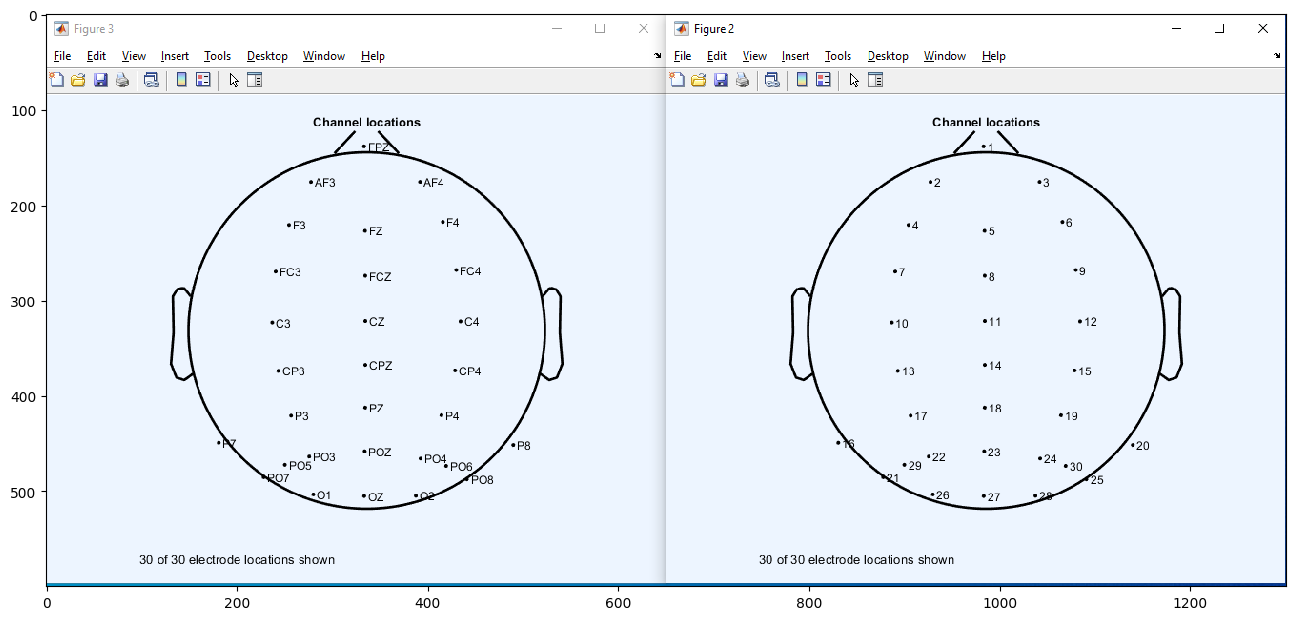


Analysing average ERPs in the electrode domain for left touch/no_touch trials ... 



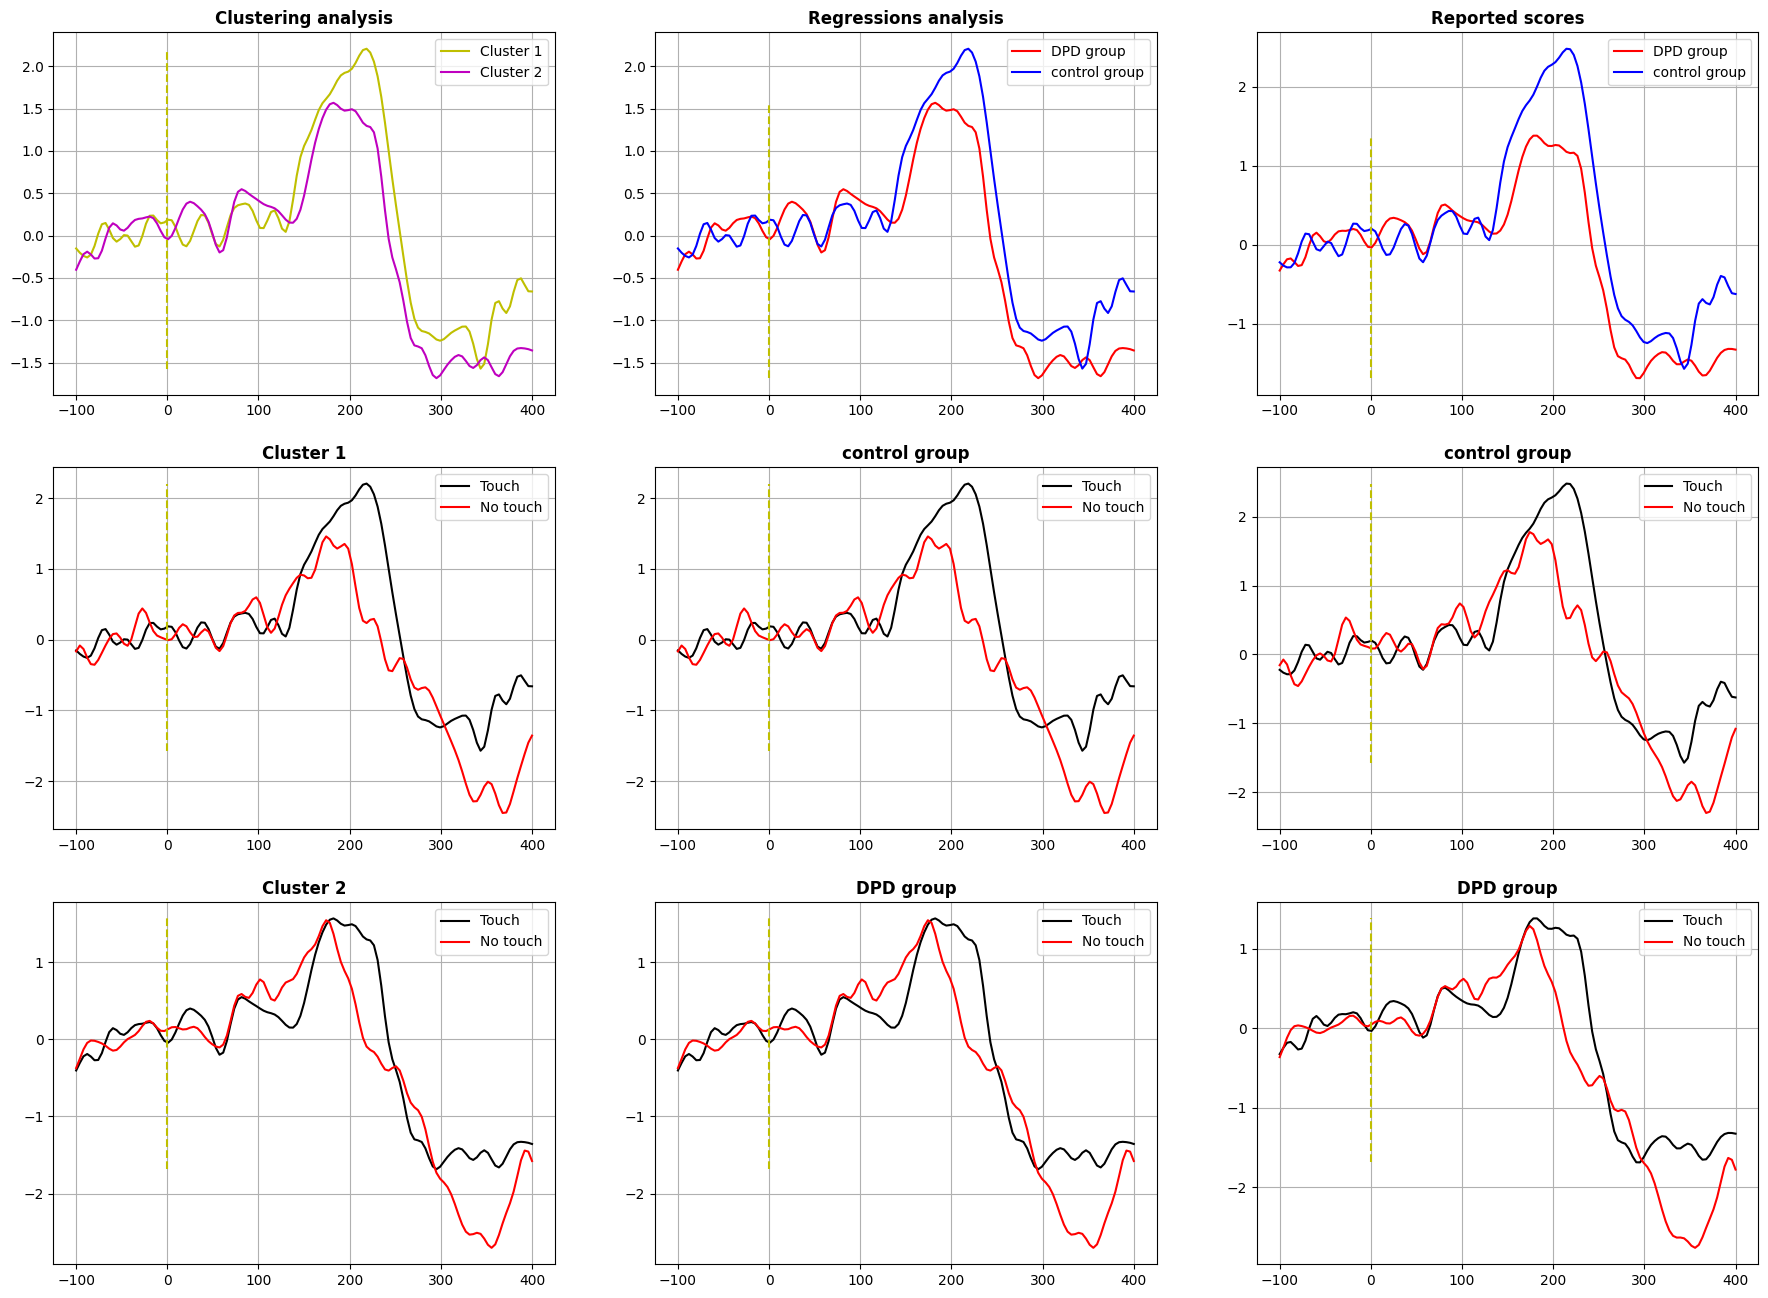


The independent t-test to analyse channels '4' between groups in 280-320ms time window:
p_value

    Clustering analysis:	0.51165
    Regressions analysis:	0.51165
    Reported scores:	0.48487


In [97]:
# Showing channel locations
plt.figure(figsize = (16,8), dpi=100)
img = mpimg.imread('Channel_loc_30.PNG')
imgplot = plt.imshow(img, interpolation='none')
plt.show()

print('\n\033[1m' + 'Analysing average ERPs in the electrode domain for ' + T_type + ' touch/no_touch trials ... ' + '\033[0m\n')
Channel_in = input('Which channels do you want to visualsie (use numbers seperated by comma)? ')   
Channel = Channel_in.split(',')
Channel = np.array([int(i)-1 for i in Channel])

L_T = X_original['Left_touch']
L_NT = X_original['Left_no_touch']
R_T = X_original['Right_touch']
R_NT = X_original['Right_no_touch']

fig, axes = plt.subplots(figsize=(22, 16), nrows=3, ncols=3)
if T_type== 'left':
    touch_signal = L_T
    no_touch_signal = L_NT
elif T_type== 'right':
    touch_signal = R_T
    no_touch_signal = R_NT
    
#------------------------------------------------------------------------
# Defining functions needed for visualisation
#------------------------------------------------------------------------
# Calculating average ERPs 
def Ave_ERP(signal, sub_idx, Channel):
    All_touch_list = [np.mean(i,0) for i in [signal[i] for i in [Z==i for i in sub_idx]]]
    All_touch = np.zeros(All_touch_list[0].shape)
    counter = 0 
    for item in All_touch_list:
        All_touch += item
        counter += 1
    All_touch /= counter
    return np.mean(All_touch[Channel,:,0], 0)

def Time_vis1(g1_sub, g2_sub, idx, title, head1, head2, c1='r', c2='b'):
    axes[0,idx].plot(t_trial, Ave_ERP(touch_signal, g1_sub, Channel), c1, label = head1)
    axes[0,idx].plot(t_trial, Ave_ERP(touch_signal, g2_sub, Channel), c2, label = head2)
    axes[0,idx].vlines(0, np.min(Ave_ERP(touch_signal, g1_sub, Channel)), 
                     np.max(Ave_ERP(touch_signal, g1_sub, Channel))
                     , colors = 'y', linestyles = 'dashed')
    axes[0,idx].set_title(title, fontweight='bold')
    axes[0,idx].legend()
    axes[0,idx].grid()
    

def Time_vis2(g1_sub, g2_sub, idx, title, head1, head2):
    axes[1,idx].plot(t_trial, Ave_ERP(touch_signal, g1_sub, Channel), 'k', label = 'Touch')
    axes[1,idx].plot(t_trial, Ave_ERP(no_touch_signal, g1_sub, Channel), 'r', label = 'No touch')
    axes[1,idx].set_title('\n'+head1, fontweight='bold')
    axes[1,idx].vlines(0, np.min(Ave_ERP(touch_signal, g1_sub, Channel)), 
                     np.max(Ave_ERP(touch_signal, g1_sub, Channel))
                     , colors = 'y', linestyles = 'dashed')
    axes[1,idx].legend()
    axes[1,idx].grid()

    axes[2,idx].plot(t_trial, Ave_ERP(touch_signal, g2_sub, Channel), 'k', label = 'Touch')
    axes[2,idx].plot(t_trial, Ave_ERP(no_touch_signal, g2_sub, Channel), 'r', label = 'No touch')
    axes[2,idx].set_title(head2, fontweight='bold')
    axes[2,idx].vlines(0, np.min(Ave_ERP(touch_signal, g2_sub, Channel)), 
                     np.max(Ave_ERP(touch_signal, g2_sub, Channel))
                     , colors = 'y', linestyles = 'dashed')
    axes[2,idx].legend()
    axes[2,idx].grid()

#------------------------------------------------------------------------

Time_vis1(C1_sub, C2_sub, 0, 'Clustering analysis', 'Cluster 1', 'Cluster 2', 'y', 'm')
Time_vis1(DPD_sub, control_sub, 1, 'Regressions analysis', 'DPD group', 'control group')
Time_vis1(DPD_sub_act, control_sub_act, 2, 'Reported scores', 'DPD group', 'control group')
    
Time_vis2(C1_sub, C2_sub, 0, 'Clustering analysis', 'Cluster 1', 'Cluster 2')
Time_vis2(control_sub, DPD_sub, 1, 'Regressions analysis', 'control group', 'DPD group')
Time_vis2(control_sub_act, DPD_sub_act, 2, 'Reported scores', 'control group', 'DPD group')
plt.show()

#------------------------------------------------------------------------
# Performing statistical analysis in the electrode domain
#------------------------------------------------------------------------
t_range = input('\nSelect time window for statistical test (low-high) >> (insert 0 to skip) ')
if t_range!= '0':
    [low, high] = [int((float(i)-start_sample)*Fs/1000) for i in t_range.split('-')]

    print("""\nThe independent t-test to analyse channels %r between groups in %sms time window:\np_value\n
    Clustering analysis:\t%2.5f
    Regressions analysis:\t%2.5f
    Reported scores:\t%2.5f"""
    % (Channel_in, t_range,
       stats.ttest_ind([np.mean(i[Channel,low:high,:]) for i in \
                        [np.mean(i,0) for i in [touch_signal[i] for i in [Z==i for i in C1_sub]]]],
                       [np.mean(i[Channel,low:high,:]) for i in \
                        [np.mean(i,0) for i in [touch_signal[i] for i in [Z==i for i in C2_sub]]]]).pvalue,
       stats.ttest_ind([np.mean(i[Channel,low:high,:]) for i in \
                        [np.mean(i,0) for i in [touch_signal[i] for i in [Z==i for i in DPD_sub]]]],
                       [np.mean(i[Channel,low:high,:]) for i in \
                        [np.mean(i,0) for i in [touch_signal[i] for i in [Z==i for i in control_sub]]]]).pvalue,
       stats.ttest_ind([np.mean(i[Channel,low:high,:]) for i in \
                        [np.mean(i,0) for i in [touch_signal[i] for i in [Z==i for i in np.unique(Z[Y>=Thr_common])]]]],
                       [np.mean(i[Channel,low:high,:]) for i in \
                        [np.mean(i,0) for i in [touch_signal[i] for i in [Z==i for i in np.unique(Z[Y<Thr_common])]]]]).pvalue))